In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Sampler,Estimator
import pickle 
import time
from qiskit.circuit.library import iSwapGate


In [2]:
J=1
nQ=3
n_qubits=3*nQ
sqrt_iSWAP = iSwapGate().power(1/2)

In [3]:
def add3Q(circuit,tmpIndex,alpha=J):
    tmpIndex1=(tmpIndex+1)%(n_qubits)
    tmpIndex2=(tmpIndex+2)%(n_qubits)
    
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    #circuit.barrier()
    circuit.rz(np.pi,tmpIndex)
    circuit.rz(-np.pi/4,tmpIndex1)
    circuit.rz(-np.pi/4,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    
    circuit.rz(np.pi-alpha,tmpIndex1)
    circuit.rz(alpha,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    circuit.rz(np.pi/4,tmpIndex1)
    circuit.rz(np.pi/4,tmpIndex2)
    #circuit.barrier()
            
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    
    

In [18]:
def getTrotterCircuit(n_qubits,J,nTrotter=2,fFactor=0.2,dtFactor=0.2):
    f=fFactor*J
    dt=dtFactor/J
    
    circuit = QuantumCircuit(n_qubits)
    #circuit = QuantumCircuit(n_qubits,n_qubits)
    
    center_index=np.ceil((n_qubits-1)/2)
    if center_index%2==1:
        center_index+=1
    #First produce the initial state:
    for i in range(n_qubits):
   
        if i!=center_index:
            if i%2!=0:
                circuit.h(i)
                
            else:
                circuit.x(i)
 
    #Trotterization:
    for step in range(nTrotter):
        
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/4)):
            tmpIndex=i*4
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        n_end=0# no period
        for i in range(int(n_qubits/4)-n_end):
            tmpIndex=i*4+2
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/2)):
            tmpIndex=i*2
            circuit.rz(0,tmpIndex)
            circuit.rx(f*dt,tmpIndex+1)
        #Adding last rotation gate if it is an odd number
        if tmpIndex+1 == n_qubits-2:
            circuit.rz(0,tmpIndex+2)
            
    return circuit
    
    
    

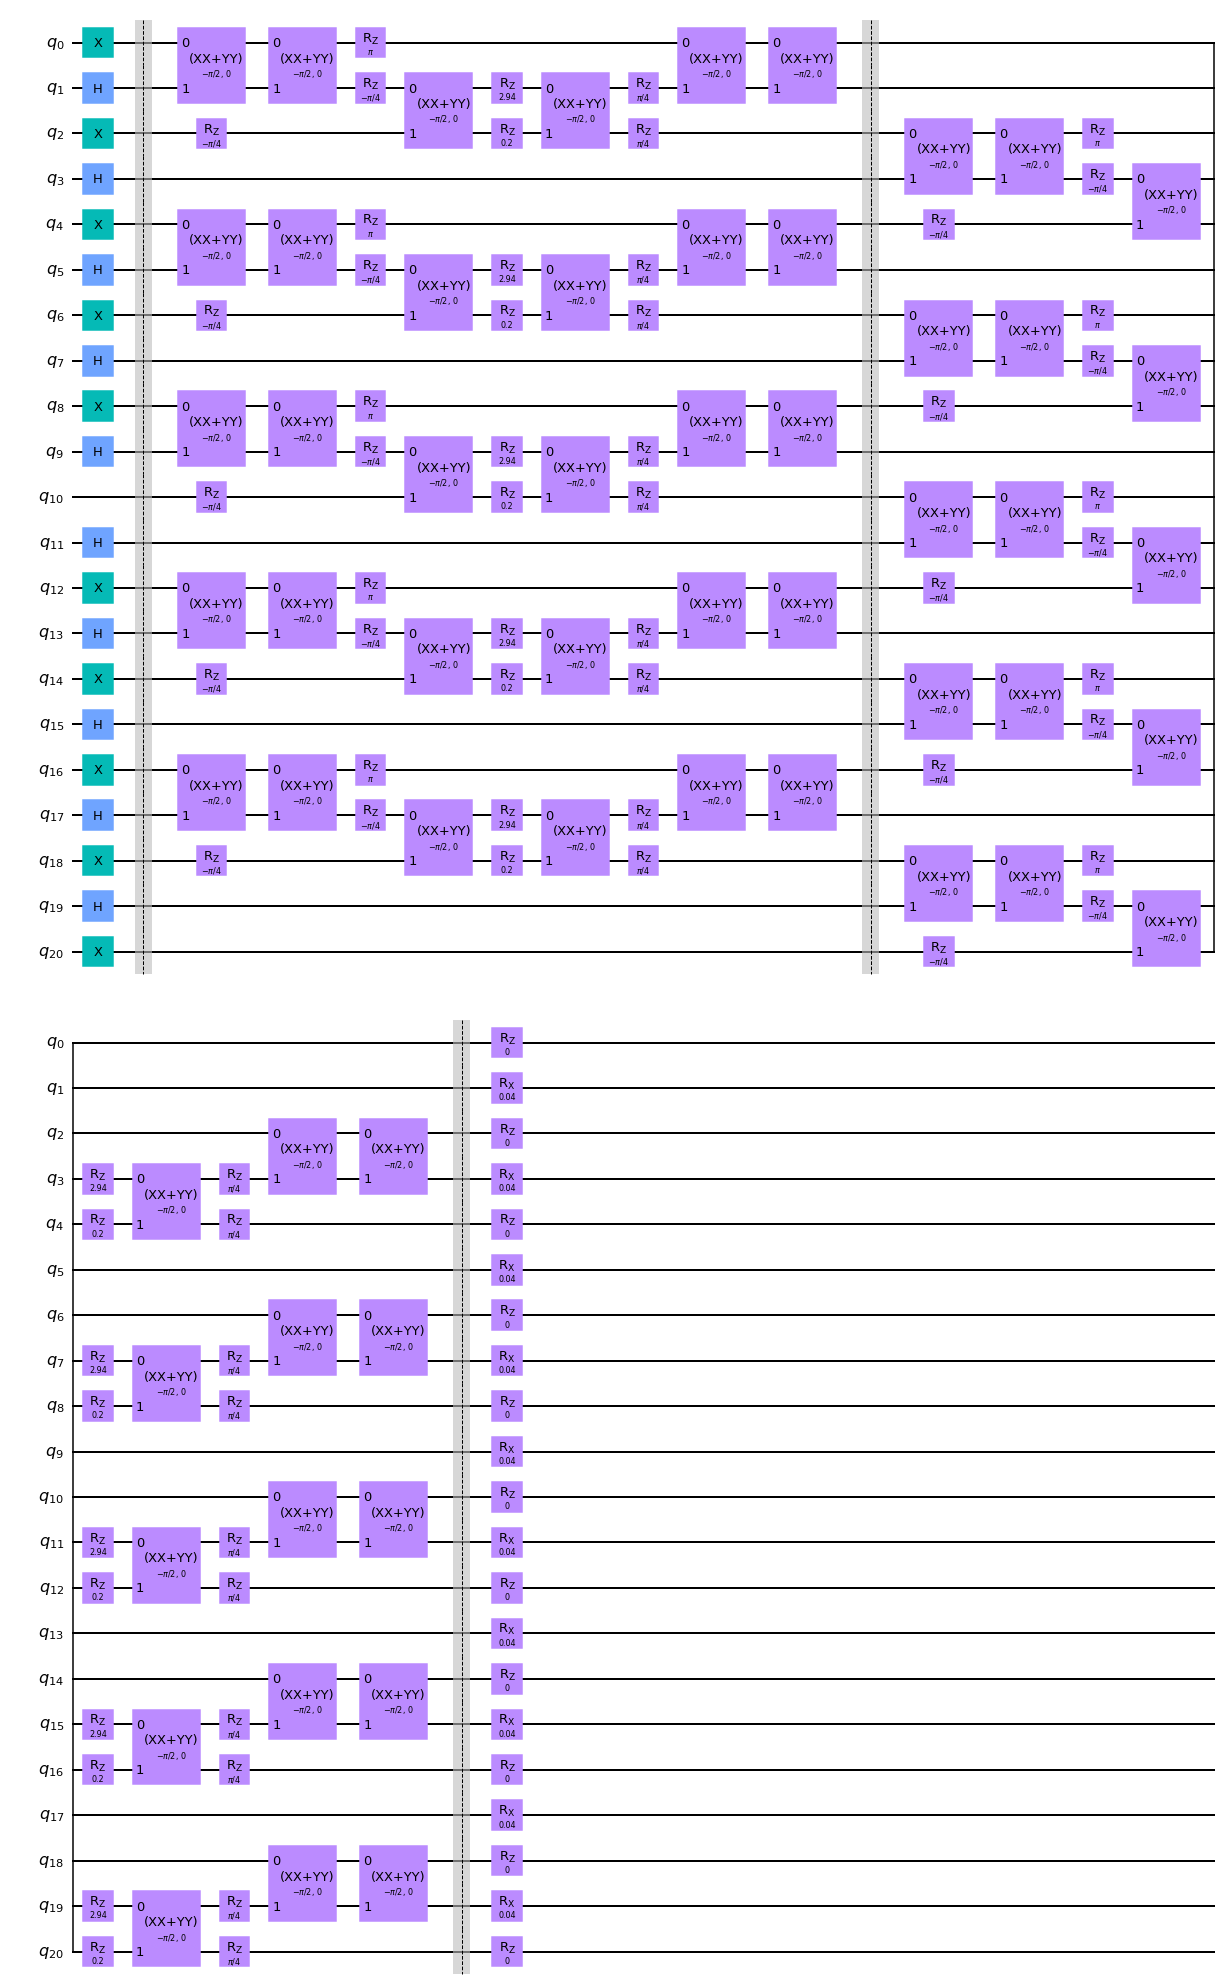

In [19]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=1)
circuit.draw('mpl')

In [8]:
observable_list=[]
for i in range(n_qubits):
    if i%2!=0:
        observable=SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-i-1) , 1)])
        observable_list.append(observable)
        
    else:
  
        observable=SparsePauliOp.from_list([("I"*(i)+"Z"+"I"*(n_qubits-i-1) , -1)])
        observable_list.append(observable)
print(observable_list)


[SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IXIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIXIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIXIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIXIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIZIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIXIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIZIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIIIXIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIZIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIXIIIIIII'],
  

In [9]:
dtFactor=0.2
nSteps=30

<Figure size 432x288 with 0 Axes>

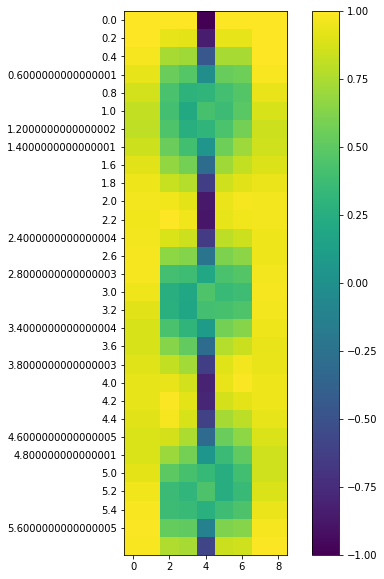

29  steps results =  [ 0.97776489  0.97776489  0.75865943  0.73642433 -0.58011604  0.84369172
  0.85494957  0.98874215  0.98874215]
time taken =  0.5439438819885254


In [15]:
estimator=Estimator()
results_list_2=[]
for i in range(nSteps):
    t_start=time.time()
    
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=2,dtFactor=dtFactor)

    job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=None)
    results=np.array(job.result().values)
    results_list_2.append(results)
    #print(i)   
    
    clear_output(wait=True)
    plt.figure(1)
    plt.figure(figsize=(9,10))
    plt.imshow(results_list_2, interpolation='none')
    plt.colorbar()
    y=dtFactor*J*np.arange(0,i,1)
    plt.yticks(range(len(y)), y)
    plt.show()
    print(i," steps results = ",results)
    print("time taken = ",time.time()-t_start)
    
results_list_2=np.array(results_list_2)

<Figure size 432x288 with 0 Axes>

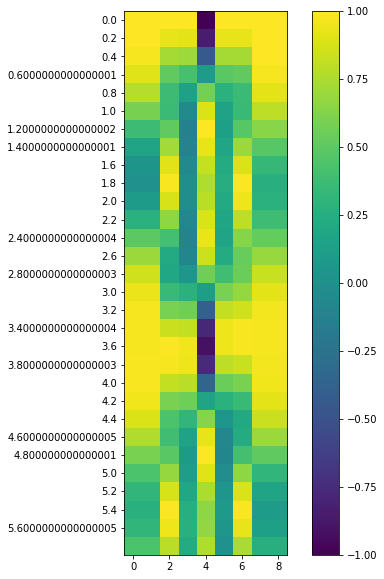

29  steps results =  [0.43412736 0.43412736 0.79438369 0.22851105 0.7613882  0.01010075
 0.74641226 0.26368849 0.26368849]
time taken =  0.5431151390075684


In [16]:
estimator=Estimator()
results_list_2en2=[]

for i in range(nSteps):
    t_start=time.time()
    circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=0.2,dtFactor=dtFactor)
    job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=None)
    results=np.array(job.result().values)
    results_list_2en2.append(results)
    
    
    clear_output(wait=True)
    plt.figure(1)
    plt.figure(figsize=(9,10))
    plt.imshow(results_list_2en2, interpolation='none')
    plt.colorbar()
    y=dtFactor*J*np.arange(0,i,1)
    plt.yticks(range(len(y)), y)
    plt.show()
    print(i," steps results = ",results)
    print("time taken = ",time.time()-t_start)
    
results_list_2en2=np.array(results_list_2en2)

In [20]:
nQ=7
n_qubits=3*nQ

observable_list=[]
for i in range(n_qubits):
    if i%2!=0:
        observable=SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-i-1) , 1)])
        observable_list.append(observable)
        
    else:
  
        observable=SparsePauliOp.from_list([("I"*(i)+"Z"+"I"*(n_qubits-i-1) , -1)])
        observable_list.append(observable)
print(observable_list)


[SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IXIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIXIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIIIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIXIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZIIIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIXIIIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIZIIIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIXIIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIZIIIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIIIXIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIZIIIIIIII'],
              coeffs=[-1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIXIIIIIII'],
  

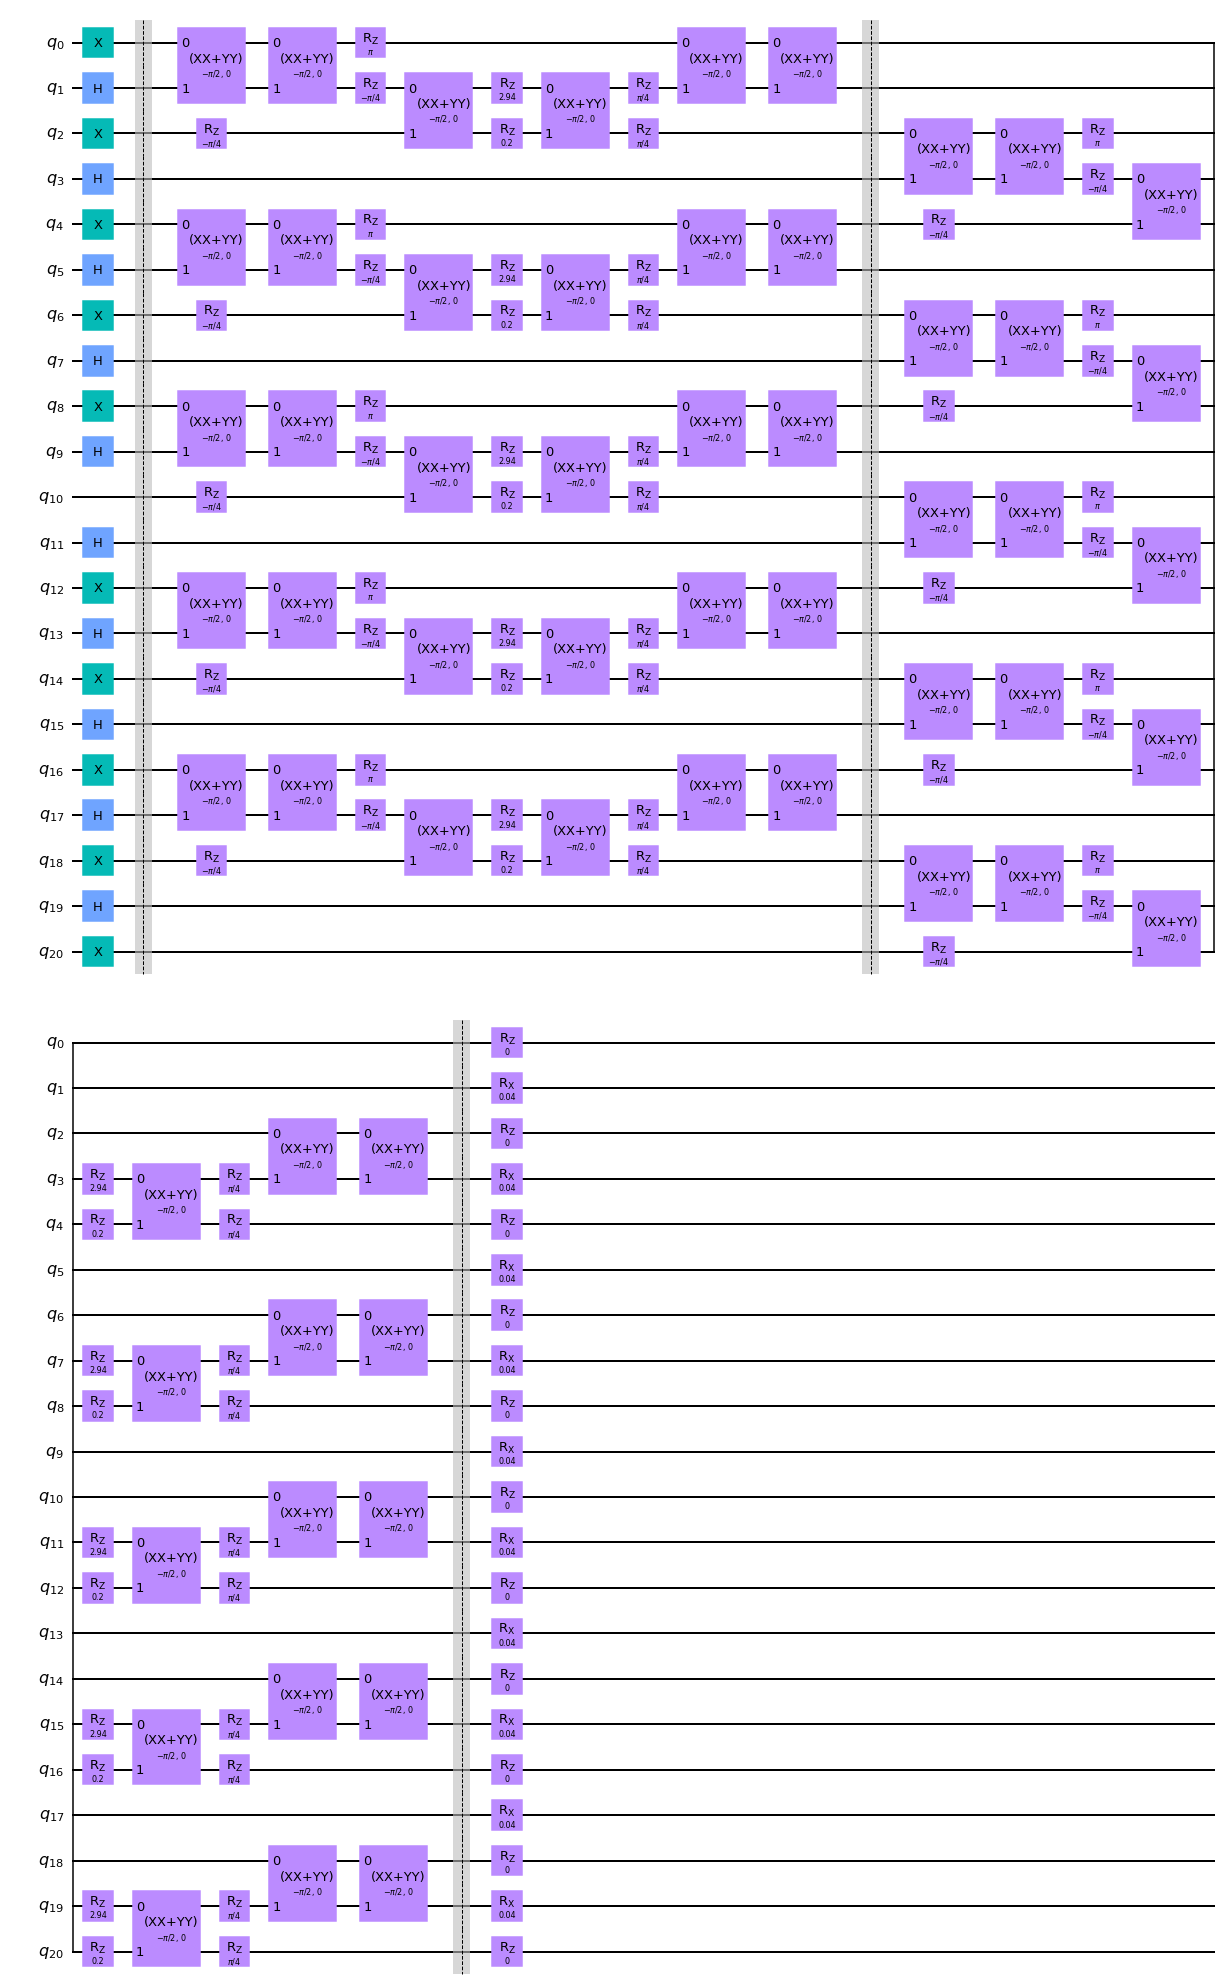

In [21]:
circuit = getTrotterCircuit(n_qubits,J,nTrotter=1,fFactor=0.2,dtFactor=dtFactor)
circuit .draw("mpl")

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [23]:
service = QiskitRuntimeService()

In [24]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Estimator
from qiskit.providers.fake_provider import FakeManila

backend_realDevice=service.get_backend('ibmq_kolkata')

noise_model = NoiseModel.from_backend(backend_realDevice)

simulator = service.get_backend('ibmq_qasm_simulator')
simulator.set_options(noise_model=noise_model)

simulator_noNoise = service.get_backend('ibmq_qasm_simulator')

In [25]:
# Set options to include the noise model with error mitigation
options0= Options(resilience_level=0)
options1= Options(resilience_level=1)
#options.optimization_level = 0 # no optimization
#options.resilience_level = 0 # M3 for Sampler and T-REx for Estimator

In [30]:
nEvents=1
nShots=2**14
print(nShots)

16384


In [32]:
nSteps=25
job_2_list=[]

with Session(service=service, backend=simulator) as session:
    estimator = Estimator(session=session,options=options0)
    
    for i in range(nSteps):

        
        circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=2,dtFactor=dtFactor)
        job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=nShots)
        job_2_list.append(job)
    
    print("finished")
    
results_2=[]
for job in job_2_list:
    t_start=time.time()
    results_2.append(job.result().values)
    print(time.time()-t_start)
    
results_2=np.array(results_2)


    

<Figure size 432x288 with 0 Axes>

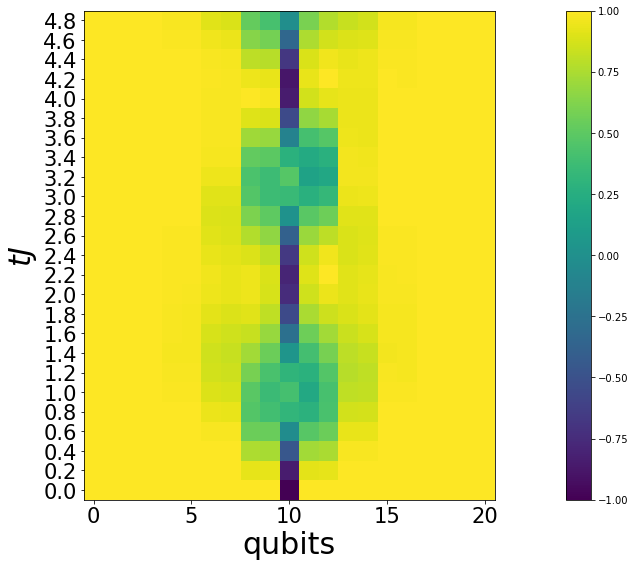

In [34]:
results_2=results_2[0:nSteps]
LabelSize=30
plt.figure(1)
plt.figure(figsize=(16,9))
plt.imshow(results_2, interpolation='none',origin='lower')

y=dtFactor*J*np.arange(0,len(results_2),1)
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize*0.7)
plt.colorbar(fraction=0.03, pad=0.08)
plt.show()

finished
1.840580701828003
2.2886340618133545
1.9834811687469482
4.185673952102661
3.6064817905426025
8.60116195678711
2.7449121475219727
15.209105014801025
8.555655002593994
4.54735803604126
6.310235261917114
2.1762499809265137


<Figure size 432x288 with 0 Axes>

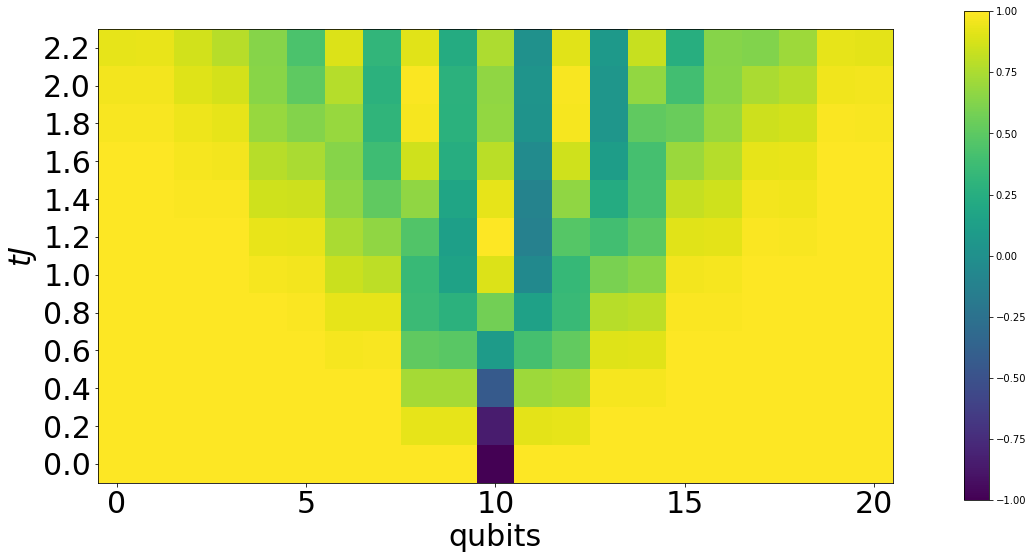

In [29]:
nSteps=12
job_2en2_list=[]

with Session(service=service, backend=simulator) as session:
    estimator = Estimator(session=session,options=options0)
    
    for i in range(nSteps):

        circuit = getTrotterCircuit(n_qubits,J,nTrotter=i,fFactor=0.2,dtFactor=dtFactor)
        job=estimator.run(circuits=[circuit]*len(observable_list), observables=observable_list,shots=nShots)
        job_2en2_list.append(job)
    
    print("finished")

results_2en2=[]
for job in job_2en2_list:
    t_start=time.time()
    results_2en2.append(job.result().values)
    print(time.time()-t_start)
    
results_2en2=np.array(results_2en2)
results_2en2=results_2en2[0:nSteps]

LabelSize=30
plt.figure(1)
plt.figure(figsize=(16,9))
plt.imshow(results_2en2, interpolation='none',origin='lower')

y=dtFactor*J*np.arange(0,len(results_2en2),1)
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.colorbar(fraction=0.03, pad=0.08)
plt.show()
    

<Figure size 432x288 with 0 Axes>

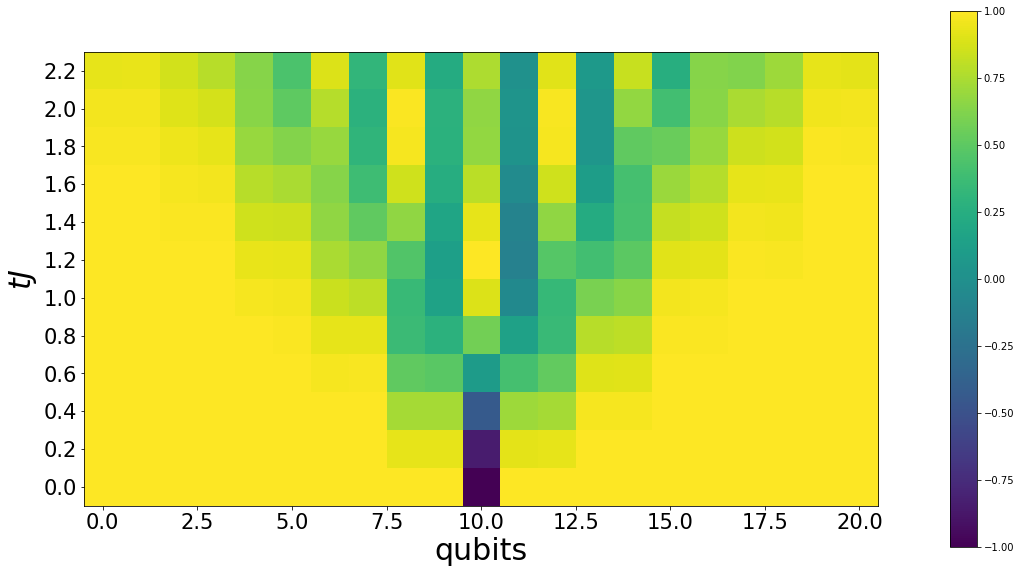

<Figure size 432x288 with 0 Axes>

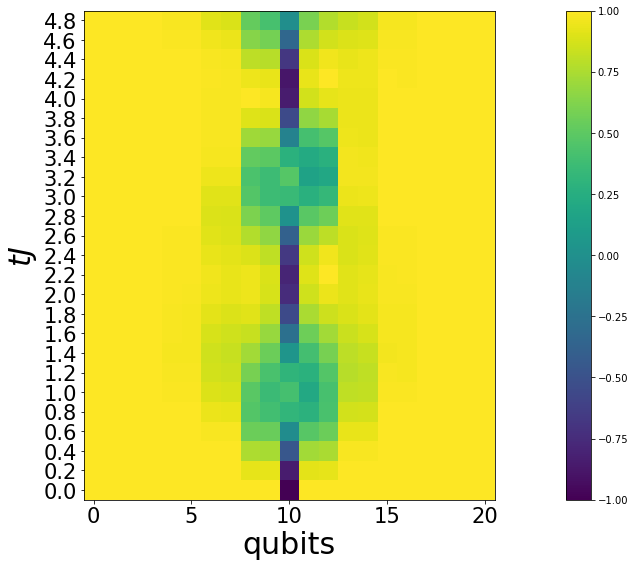

In [39]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(16,96))
plt.imshow(results_2en2, interpolation='none',origin='lower')

y=dtFactor*J*np.arange(0,len(results_2en2),1)
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize*0.7)
plt.colorbar(fraction=0.03, pad=0.08)
plt.show()

plt.figure(2)
plt.figure(figsize=(16,9))
plt.imshow(results_2, interpolation='none',origin='lower')

y=dtFactor*J*np.arange(0,len(results_2),1)
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=LabelSize)
plt.ylabel(r'$tJ$',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize*0.7)
plt.colorbar(fraction=0.03, pad=0.08)
plt.show()
    